# Final Modeling with Keras
*for Health Insurance Cross Sell Prediction project*

For this model, I followed some of the strategies laid out in this [TensorFlow tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#checkpoint_the_initial_weights) for dealing with unbalanced datasets. 

#### Load Packages

In [30]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile
import requests
import io
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#### Load Data

In [15]:
# Download train.csv data from GitHub
url = "https://raw.githubusercontent.com/ssears219/Health-Insurance-Cross-Sell-Prediction/main/Data/Kaggle%20Data/train.csv"
file = requests.get(url).content

# Read to pandas df
df = pd.read_csv(io.StringIO(file.decode('utf-8')))
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [16]:
neg, pos = np.bincount(df['Response'])
total = neg + pos
print('Total: {}\nNot Interested (0): {} \nInterested (1): {} ({:.2f}%)'.format(
    total, neg, pos, 100 * pos / total))

Total: 381109
Not Interested (0): 334399 
Interested (1): 46710 (12.26%)


### Data Preparation
* Explode categorical columns Region_Code and Policy_Sales_Channel
* Scale continuous columns
* Split and Shuffle data into train, validation, and test

In [17]:
# Identify categorical, continuous, and target columns
cat_cols = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured',
               'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
continuous_cols = ['Age', 'Annual_Premium', 'Vintage']
target = ['Response']

# Convert numerical categorical columns to strings
df['Region_Code'] = df['Region_Code'].astype(str)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(str)

# Explode categorical columns
df_cat = pd.get_dummies(df[cat_cols], drop_first=True)
cat_cols = list(df_cat.columns)

# Scale continous data
scaler = StandardScaler()
for col in continuous_cols:
    x = df[col].values.reshape(-1, 1)
    df[col] = scaler.fit_transform(x)
    
# Combine all final variables
df = pd.concat([df[continuous_cols + target], df_cat], axis=1)


# Split and shuffle dataset
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features
y_train = np.array(train_df.pop('Response'))
pos_y_train = train_df != 0
y_val = np.array(val_df.pop('Response'))
y_test = np.array(test_df.pop('Response'))

x_train = np.array(train_df)
x_val = np.array(val_df)
x_test = np.array(test_df)


print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', x_train.shape)
print('Validation features shape:', x_val.shape)
print('Test features shape:', x_test.shape)

Training labels shape: (243909,)
Validation labels shape: (60978,)
Test labels shape: (76222,)
Training features shape: (243909, 215)
Validation features shape: (60978, 215)
Test features shape: (76222, 215)


### Model Functions, Variables, and Initial Weights

In [20]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def make_model(metrics=METRICS, output_bias=None):
    """
    Function that defines and compiles model
    """
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            64, activation='relu',
            input_shape=(215,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid',
                           bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

epochs = 100
batch_size = 2048

# Set initial bias
initial_bias = np.log([pos/neg])
model = make_model(output_bias=initial_bias)

# Save initial weights
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Baseline Model

In [21]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=(x_val, y_val))

Train on 243909 samples, validate on 60978 samples
Epoch 1/100
243909/243909 [==============================] - 5s 22us/sample - loss: 0.3086 - tp: 380.0000 - fp: 688.0000 - tn: 213286.0000 - fn: 29555.0000 - accuracy: 0.8760 - precision: 0.3558 - recall: 0.0127 - auc: 0.8016 - prc: 0.2922 - val_loss: 0.2707 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 53517.0000 - val_fn: 7461.0000 - val_accuracy: 0.8776 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8512 - val_prc: 0.3460
Epoch 2/100
243909/243909 [==============================] - 2s 8us/sample - loss: 0.2750 - tp: 253.0000 - fp: 396.0000 - tn: 213578.0000 - fn: 29682.0000 - accuracy: 0.8767 - precision: 0.3898 - recall: 0.0085 - auc: 0.8408 - prc: 0.3271 - val_loss: 0.2676 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 53517.0000 - val_fn: 7461.0000 - val_accuracy: 0.8776 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8537 - val_prc: 0.3558
Epoch 3/100
243909/243909 [===============

loss :  0.26527371326260707
tp :  8.0
fp :  7.0
tn :  66901.0
fn :  9306.0
accuracy :  0.87781745
precision :  0.53333336
recall :  0.0008589221
auc :  0.8551116
prc :  0.36072809

Non-Interested Customers Correctly Classified (True Negatives):  66901
Non-Interested Customers Incorrectly Classified (False Positives):  7
Interested Customers Incorrextly Classified (False Negatives):  9306
Interested Customers Correctly Classified (True Positives):  8
Total Interested Customers:  9314


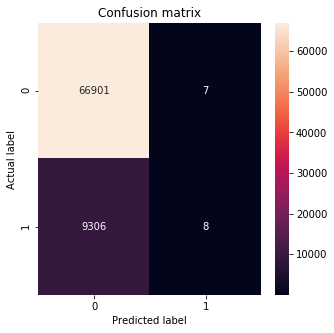

In [22]:
train_predictions = model.predict(x_train, batch_size=batch_size)
test_predictions = model.predict(x_test, batch_size=batch_size)

def plot_results(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-Interested Customers Correctly Classified (True Negatives): ', cm[0][0])
    print('Non-Interested Customers Incorrectly Classified (False Positives): ', cm[0][1])
    print('Interested Customers Incorrextly Classified (False Negatives): ', cm[1][0])
    print('Interested Customers Correctly Classified (True Positives): ', cm[1][1])
    print('Total Interested Customers: ', np.sum(cm[1]))
    
results = model.evaluate(x_test, y_test,
                                  batch_size=batch_size, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
print()

plot_results(y_test, test_predictions)

### Model using Class Weights

In [24]:
weight_0 = (1 / neg) * (total / 2.0)
weight_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_0, 1: weight_1}

print('Weight for class 0: {:.2f}'.format(weight_0))
print('Weight for class 1: {:.2f}'.format(weight_1))

Weight for class 0: 0.57
Weight for class 1: 4.08


In [25]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=(x_val, y_val),
    class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 243909 samples, validate on 60978 samples
Epoch 1/100
243909/243909 [==============================] - 5s 22us/sample - loss: 0.5854 - tp: 19697.0000 - fp: 57812.0000 - tn: 156162.0000 - fn: 10238.0000 - accuracy: 0.7210 - precision: 0.2541 - recall: 0.6580 - auc: 0.7629 - prc: 0.2573 - val_loss: 0.4415 - val_tp: 6891.0000 - val_fp: 17538.0000 - val_tn: 35979.0000 - val_fn: 570.0000 - val_accuracy: 0.7030 - val_precision: 0.2821 - val_recall: 0.9236 - val_auc: 0.8494 - val_prc: 0.3403
Epoch 2/100
243909/243909 [==============================] - 2s 9us/sample - loss: 0.4589 - tp: 26284.0000 - fp: 67658.0000 - tn: 146316.0000 - fn: 3651.0000 - accuracy: 0.7076 - precision: 0.2798 - recall: 0.8780 - auc: 0.8329 - prc: 0.3129 - val_loss: 0.4270 - val_tp: 7057.0000 - val_fp: 18561.0000 - val_tn: 34956.0000 - val_fn: 404.0000 - val_accuracy: 0.6890 - val_precision: 0.2755 - val_recall: 0.9459 - val_auc: 0.8519 - val_prc: 0.3431
Epoch

Epoch 19/100
243909/243909 [==============================] - 3s 10us/sample - loss: 0.4223 - tp: 28062.0000 - fp: 72001.0000 - tn: 141973.0000 - fn: 1873.0000 - accuracy: 0.6971 - precision: 0.2804 - recall: 0.9374 - auc: 0.8541 - prc: 0.3531 - val_loss: 0.4227 - val_tp: 6790.0000 - val_fp: 16691.0000 - val_tn: 36826.0000 - val_fn: 671.0000 - val_accuracy: 0.7153 - val_precision: 0.2892 - val_recall: 0.9101 - val_auc: 0.8566 - val_prc: 0.3628
Epoch 20/100
243909/243909 [==============================] - 3s 11us/sample - loss: 0.4226 - tp: 28021.0000 - fp: 71713.0000 - tn: 142261.0000 - fn: 1914.0000 - accuracy: 0.6981 - precision: 0.2810 - recall: 0.9361 - auc: 0.8544 - prc: 0.3517 - val_loss: 0.4213 - val_tp: 6808.0000 - val_fp: 16793.0000 - val_tn: 36724.0000 - val_fn: 653.0000 - val_accuracy: 0.7139 - val_precision: 0.2885 - val_recall: 0.9125 - val_auc: 0.8568 - val_prc: 0.3648
Epoch 21/100
243909/243909 [==============================] - 3s 11us/sample - loss: 0.4223 - tp: 27985.

243909/243909 [==============================] - 2s 10us/sample - loss: 0.4161 - tp: 27825.0000 - fp: 69110.0000 - tn: 144864.0000 - fn: 2110.0000 - accuracy: 0.7080 - precision: 0.2870 - recall: 0.9295 - auc: 0.8591 - prc: 0.3685 - val_loss: 0.4195 - val_tp: 6841.0000 - val_fp: 16940.0000 - val_tn: 36577.0000 - val_fn: 620.0000 - val_accuracy: 0.7120 - val_precision: 0.2877 - val_recall: 0.9169 - val_auc: 0.8582 - val_prc: 0.3677
Epoch 56/100
243909/243909 [==============================] - 2s 9us/sample - loss: 0.4158 - tp: 27836.0000 - fp: 68860.0000 - tn: 145114.0000 - fn: 2099.0000 - accuracy: 0.7091 - precision: 0.2879 - recall: 0.9299 - auc: 0.8597 - prc: 0.3695 - val_loss: 0.4196 - val_tp: 6820.0000 - val_fp: 16830.0000 - val_tn: 36687.0000 - val_fn: 641.0000 - val_accuracy: 0.7135 - val_precision: 0.2884 - val_recall: 0.9141 - val_auc: 0.8581 - val_prc: 0.3673
Epoch 00056: early stopping


loss :  0.4503012437824313
tp :  8494.0
fp :  21014.0
tn :  45894.0
fn :  820.0
accuracy :  0.7135473
precision :  0.28785414
recall :  0.9119605
auc :  0.85504526
prc :  0.35967702

Non-Interested Customers Correctly Classified (True Negatives):  45894
Non-Interested Customers Incorrectly Classified (False Positives):  21014
Interested Customers Incorrextly Classified (False Negatives):  820
Interested Customers Correctly Classified (True Positives):  8494
Total Interested Customers:  9314


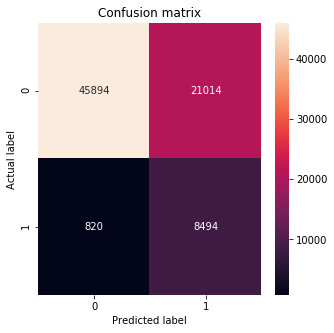

In [28]:
train_predictions_weighted = weighted_model.predict(x_train, batch_size=batch_size)
test_predictions_weighted = weighted_model.predict(x_test, batch_size=batch_size)

weighted_results = weighted_model.evaluate(x_test, y_test,
                                           batch_size=batch_size, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_results(y_test, test_predictions_weighted)

#### Save Model

In [31]:
current_dir = Path(os.getcwd()).absolute()
file_name = 'Weighted_NN_model.h5'
f_path = current_dir.joinpath(file_name)
model.save(f_path)

### Customer Segmentation Using the Model

In [32]:
probs = [x[0] for x in test_predictions_weighted]
comp_df = pd.DataFrame({'Actual': y_test, 'Predicted': probs})

bounds = []
interval_totals = []
interested_totals = []
for bound in range(0,91,10):
    bound = bound/100
    interval = comp_df[(comp_df['Predicted'] >= bound) & (comp_df['Predicted'] < bound+.1)]
    bounds.append('{:.1f}-{:.1f}'.format(bound, bound+.1))
    interested_totals.append(interval[interval['Actual'] == 1].shape[0])
    interval_totals.append(interval.shape[0])

    
comp_plot_df = pd.DataFrame({'Probability': bounds, 'Interval Total': interval_totals, 'Interested': interested_totals})
comp_plot_df['Not Interested'] = comp_plot_df['Interval Total'] - comp_plot_df['Interested']
comp_plot_df

,Probability,Interval Total,Interested,Not Interested
0,0.0-0.1,36212,58,36154
1,0.1-0.2,2184,62,2122
2,0.2-0.3,2583,138,2445
3,0.3-0.4,2752,237,2515
4,0.4-0.5,2983,325,2658
5,0.5-0.6,3734,608,3126
6,0.6-0.7,6511,1428,5083
7,0.7-0.8,15702,4998,10704
8,0.8-0.9,3561,1460,2101
9,0.9-1.0,0,0,0


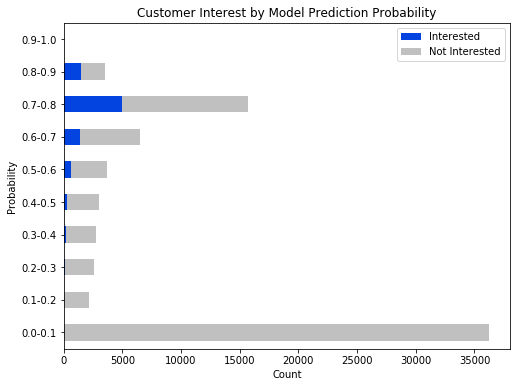

In [33]:
chart_df = comp_plot_df[['Probability', 'Interested', 'Not Interested']].set_index('Probability')

ax = chart_df.plot(kind='barh',
                   stacked=True,
                   label="Series",
                   color=['#0343DF','#C0C0C0'],
                   figsize=(8,6))

ax.set_xlabel('Count')
ax.set_ylabel('Probability')
ax.set_title('Customer Interest by Model Prediction Probability')
ax.legend(loc=1,
          labels = ['Interested', 'Not Interested'])

plt.show()